# Import all necessary libraries and data

In [269]:
# !pip install folium

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud
import folium
from sklearn.impute import SimpleImputer
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
import lightgbm as lgb

import time

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold

In [66]:
# load apartment rent prices dataset
df = pd.read_csv("/content/drive/MyDrive/flats_info_cumulative_data_4_days.csv")
# df.drop(columns="Unnamed: 0", inplace=True)
df.head(3)

Ціна оренди (грн) Ціна оренда (usd)   Місто           Район Мікрорайон  \
0             9 000               218  Харків  Шевченківський        NaN   
1             8 000               193  Харків  Шевченківський        NaN   
2             7 000               169  Харків  Шевченківський        NaN   

      Метро               Вулиця Номер будинку         Назва ЖК  \
0  Перемога  вул. Домобудівельна            13  ЖК Архітекторів   
1   Наукова     вул. Клочківська           195              NaN   
2       NaN           вул. Мирна            19    ЖК River Town   

   Загальна площа  ...  Комісія  Тип стіни (опис)        Опалення  \
0            40.0  ...        0             цегли             NaN   
1            84.0  ...        0           панелей  централізоване   
2            44.0  ...        0               NaN             NaN   

            Підігрів води           Приміщення  \
0  централізований|бойлер    суміжний санвузол   
1     бойлер|комбінований  роздільний санвузол   
2                     NaN                  NaN   

                                           Зручності           Розташування  \
0  Wi-Fi|телевізор|обідня зона|пральна машина|душ...  тип двору: внутрішній   
1  Wi-Fi|телевізор|пральна машина|ванна|духова ша...  тип двору: внутрішній   
2                                                NaN  тип двору: внутрішній   

      Планування               Ліфт  Агенство  
0            NaN  пасажирський ліфт       NaN  
1  балкон/лоджія                NaN       NaN  
2            NaN                NaN       NaN  

[3 rows x 50 columns]

In [67]:
# let's see on the dataset structure more detail
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Ціна оренди (грн)       1235 non-null   object 
 1   Ціна оренда (usd)       1235 non-null   object 
 2   Місто                   1235 non-null   object 
 3   Район                   1201 non-null   object 
 4   Мікрорайон              291 non-null    object 
 5   Метро                   988 non-null    object 
 6   Вулиця                  1227 non-null   object 
 7   Номер будинку           1229 non-null   object 
 8   Назва ЖК                208 non-null    object 
 9   Загальна площа          1235 non-null   float64
 10  Житлова площа           750 non-null    float64
 11  Площа кухні             1088 non-null   float64
 12  Поверх                  1235 non-null   int64  
 13  Всього поверхів         1235 non-null   int64  
 14  Кімнат                  1235 non-null   

# Preprocessing data

At first glance we have a lot of missing values. So let's take a look more detail on this.

In [68]:
# let's see what columns have majority of missing values (more than 50%)
over_50_perc_nan_df = pd.DataFrame({"col_name": [], "nan_%": [], "dtype": []})

missing_values = df.isnull().sum()
columns_with_missing_values = [x for x in df if df[x].isnull().sum()>0]
for col in columns_with_missing_values:
  nan_count = df[col].isnull().sum()
  if df[col].isnull().sum() > (df.shape[0]/2):
    row_record = pd.DataFrame({"col_name": [col], "nan_%": [nan_count/df.shape[0]], "dtype": df[col].dtype})
    over_50_perc_nan_df = pd.concat([over_50_perc_nan_df, row_record], ignore_index=True)

over_50_perc_nan_df.sort_values(by="nan_%", ascending=False)

col_name     nan_%    dtype
2      Спальні місця  0.846154  float64
1           Назва ЖК  0.831579   object
4   Комуналка влітку  0.813765  float64
3   Комуналка взимку  0.812955  float64
0         Мікрорайон  0.764372   object
9         Планування  0.700405   object
5       Рік побудови  0.674494  float64
8         Приміщення  0.591093   object
11          Агенство  0.583806   object
7      Підігрів води  0.569231   object
6           Опалення  0.559514   object
10              Ліфт  0.515789   object

These are the columns that should be removed from the dataset because it has more than 50 percent missing values. However, this definitely applies to numeric values (not always, we could just indicate that some factors have missing value as 1 and not as 0). As for the categorical and text ones, we will leave them for further research and trying to use them for create new factors.

In [69]:
# checking whether another wall type column provides additional information
len(df[(df["Тип стін"].isna()) & (df["Тип стіни (опис)"].notna())])

0

## First preprocessing

In [70]:
# let's make first preprocessing stuff with data

df.rename(columns={"Кімнат": "Кількість кімнат"}, inplace=True)
df["Район"].replace("Московський", "Салтівський", inplace=True)
df["Дата"] = df["Дата"].str.replace(r"[.\-]", "", regex=True)
df["Дата"] = pd.to_datetime(df["Дата"], format='%Y%m%d')
df["Ціна оренди (грн)"] = df["Ціна оренди (грн)"].str.replace(" ", "").astype(float)
# df["Ціна оренда (usd)"] = df["Ціна оренда (usd)"].str.replace(" ", "").astype(float)

# drop unnecessary columns
df.drop(columns=["Спальні місця", "Комуналка влітку", "Комуналка взимку",
                  "Рік побудови", "Тип стіни (опис)", "Посилання",
                 "Ціна оренда (usd)"], inplace=True)

# rename all type of wall values in ukrainian
df['Тип стін'].replace({
    'кирпич': 'цегла',
    'каркасно-панельный': 'каркасно-панельний',
    'монолитно-кирпичный': 'монолітно-цегляний',
    'керамический блок': 'керамічний блок',
    'монолитно-каркасный': 'монолітно-каркасний',
    'монолит': 'моноліт',
    'силикатный кирпич': 'силікатна цегла',
    'монолитный железобетон': 'монолітний залізобетон',
    'керамзитобетон': 'керамзітобетон',
    'монолитно-блочный': 'монолітно-блоковий',
    'пеноблок': 'піноблок'
}, inplace=True)

## The most frequency words in rent offers description of real-estate

In the next section I will try to find the most frequency word by each apartment description to fill categorical (text) missing values

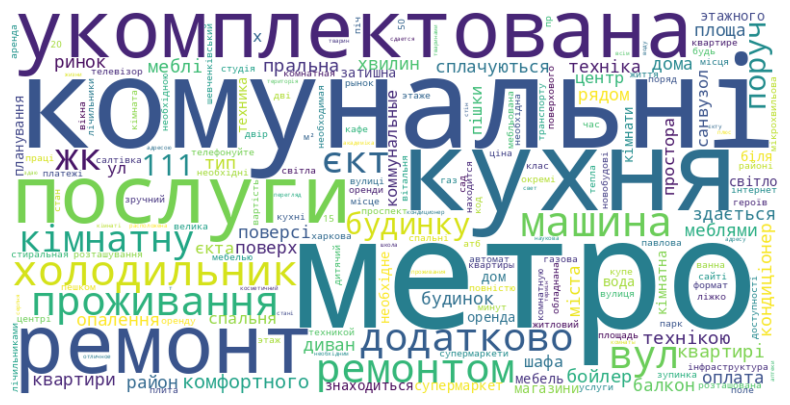

In [71]:
# let's take a look for the most frequency word in apartment descriptions

raw_text = " ".join(df["Опис"].dropna()).lower()
words = re.findall(r'\b\w+\b', raw_text.lower())
word_count = Counter(words)

stop_words_ru = set([
    'и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то',
    'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за',
    'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще',
    'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли',
    'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь',
    'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей',
    'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя',
    'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже',
    'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому',
    'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой',
    'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'сказать',
    'всех', 'никогда', 'сегодня', 'можно', 'при', 'наконец', 'два', 'об',
    'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас',
    'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя',
    'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть',
    'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'
])

stop_words_ua = set([
    'і', 'в', 'во', 'не', 'що', 'він', 'на', 'я', 'з', 'зі', 'як', 'а', 'то',
    'все', 'вона', 'так', 'його', 'але', 'також', 'ти', 'до', 'по', 'теж',
    'тільки', 'її', 'мені', 'було', 'ось', 'від', 'мене', 'ще', 'немає', 'про',
    'із', 'йому', 'тепер', 'коли', 'навіть', 'ну', 'вдруг', 'чи', 'вже', 'або',
    'ні', 'бути', 'був', 'нього', 'до', 'вас', 'нібудь', 'знову', 'вже', 'вам',
    'адже', 'там', 'потім', 'себе', 'нічого', 'їй', 'може', 'вони', 'тут',
    'де', 'є', 'треба', 'неї', 'ми', 'тебе', 'їх', 'чим', 'була', 'сам',
    'щоб', 'без', 'ніби', 'чого', 'раз', 'також', 'собі', 'під', 'буде', 'ж',
    'тоді', 'хто', 'цього', 'того', 'тому', 'ця', 'такий', 'один', 'майже',
    'мій', 'тим', 'щоб', 'неї', 'зараз', 'були', 'куди', 'навіщо', 'сказати',
    'всіх', 'ніколи', 'сьогодні', 'можна', 'при', 'нарешті', 'два', 'про',
    'інший', 'хоч', 'після', 'над', 'більше', 'цей', 'через', 'ці', 'нас',
    'про', 'них', 'який', 'багато', 'хіба', 'три', 'цю', 'моя', 'втім',
    'добре', 'свою', 'цієї', 'перед', 'іноді', 'краще', 'трохи', 'він',
    'не можна', 'такий', 'ним', 'більш', 'завжди', 'звісно', 'всю', 'між'
])

stop_words = set(["в", "та", "на", "для", "1", "2", "3", "4", "5", "6",
    "7", "8", "9", "/", ",", "з", "и", "і", "вул.", "З",
    "м.", "без", "+", "-", "грн", "от", "від", "не", "вся",
    "по", "до", "у", "с", "є", "за", "здам", "квартира", "все",
    "сдам", "вас", "що", "кв.", "всі", "10", ".", ":", "грн.",
    "ми", "id", "а", "дод.", "2-х", "як", "или", "кв", "ком",
    "что", "м", "м2", "кім.", "12", "к", "хв", "із", "квартиру",
    "есть", "дуже", "грн.", "(", ")", "із", "23", "2-х", "хв",
    "3-х", "хв", "к", "або", "или", "из", "16", "очень", "1к",
    "ми", "зі", "всё"])

filtered_words = [word for word in words if word not in stop_words_ru and word not in stop_words_ua and word not in stop_words]

filtered_word_count = Counter(filtered_words)

total_clean_frequency = filtered_word_count.most_common()

# make a cloud of word and than show the plot
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(total_clean_frequency))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

On the picture we see "ЖК" what probably means some type of connection with our columns "Назва ЖК". Also we can see metro, what can help to mark apartment nearby metro station and other useful things to fill missing values.

In [72]:
# make a dataframe for this words
total_clean_frequency_df =  pd.DataFrame(total_clean_frequency)
total_clean_frequency_df.rename(columns={0: "feature", 1: "count"}, inplace=True)

In [73]:
# save for the furture analysis
# total_clean_frequency_df.to_csv("/content/drive/MyDrive/most_frequency_word.csv")

In [74]:
# probably we should check how it works
filtered_df = df[df['Опис'].str.contains("жк", case=False, na=False)]
filtered_df.iloc[6, 20]

'Довгострокова оренда  затишної, світлої 1 кімнатної квартири зі свіжим ремонтом в ЖК Перемога на Олексіївці, в безпосередній близькості від лісопаркової зони. До метро Перемога 13 хв. пішки.\nКвартира розташована на середньому 4 поверсі, мебльована та обладнана всією необхідною технікою для комфортного життя: холодильник, пральна машина, бойлер, кондиціонер, плита комбінована , витяжка.У квартирі встановлені лічильники на світло, газ, воду та тепло, є можливість регулювання подачі тепла, чим можна заощадити на оплаті за опалення. Велика засклена лоджія.\nЖК "Перемоги" - житловий комплекс в спокійному, зеленому районі на Олексіївці. Тут відсутні промислові підприємства . За декілька кроків чиста лісопаркова зона.\nУ дворі великий дитячий майданчик, поряд зупинка транспорту, садок, школа. У пішій доступності від ЖК знаходяться: гіпермаркети "Епіцентр" та "Караван", ТЦ METRO, супермаркети "АТБ", "Сільпо", "Клас", великі магазини побутової техніки, ринок, АЗС.\nБез тварин!'

From this apartment description we can get significant infromation for our research. For example, we get from this "ЖК Перемога", what automaticaly means that this apartment from specific residential complex. Also can observe another interesting information like "air conditioner", "boiler" or hypermarkets like "АТБ", "Клас" and "Сільпо", which can affect the price.

But before we start extract information from description and make another preprocessing things let's take a look on original data.

## Look on original data about city real-estate market

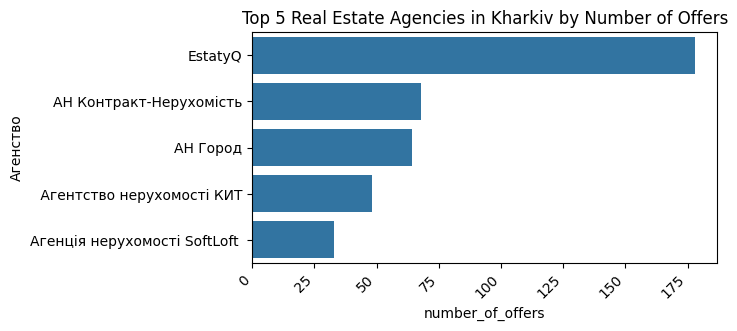

In [75]:
# the biggest agency (top 5) on the Kharkiv real estate market
t1_df = df.groupby("Агенство").size().reset_index(name="number_of_offers").sort_values(by="number_of_offers", ascending=False).head(5)

plt.figure(figsize=(6, 3))
sns.barplot(y="Агенство", x="number_of_offers", data=t1_df)
plt.xticks(rotation=45, ha="right")
plt.title("Top 5 Real Estate Agencies in Kharkiv by Number of Offers")
plt.show()

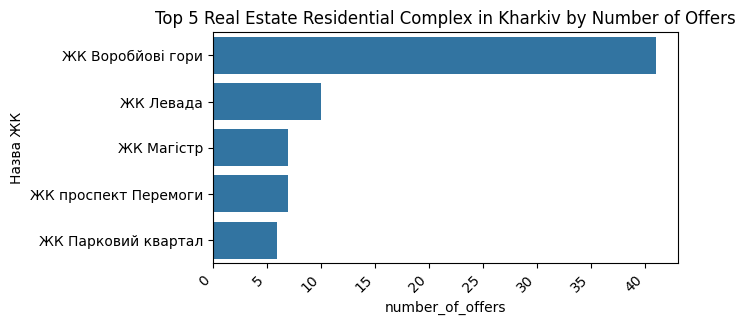

In [76]:
# and the biggest residential complex (top 5) on the Kharkiv real estate market
t2_df = df.groupby("Назва ЖК").size().reset_index(name="number_of_offers").sort_values(by="number_of_offers", ascending=False).head(5)

plt.figure(figsize=(6, 3))
sns.barplot(y="Назва ЖК", x="number_of_offers", data=t2_df)
plt.xticks(rotation=45, ha="right")
plt.title("Top 5 Real Estate Residential Complex in Kharkiv by Number of Offers")
plt.show()

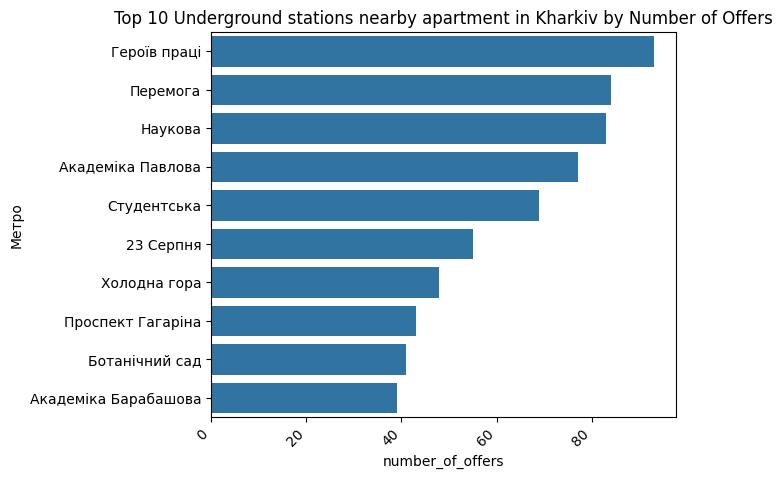

In [77]:
# most popular underground stations nearby apartments
t3_df = df.groupby("Метро").size().reset_index(name="number_of_offers").sort_values(by="number_of_offers", ascending=False).head(10)

plt.figure(figsize=(6, 5))
sns.barplot(y="Метро", x="number_of_offers", data=t3_df)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Underground stations nearby apartment in Kharkiv by Number of Offers")
plt.show()

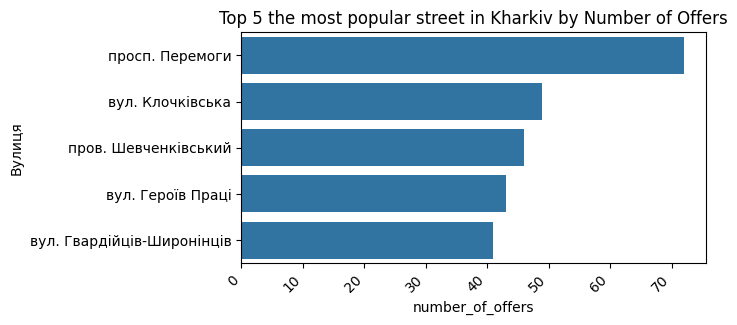

In [78]:
# Kharkiv street with the most offers of apartments (top 5) on the Kharkiv real estate market
t4_df = df.groupby("Вулиця").size().reset_index(name="number_of_offers").sort_values(by="number_of_offers", ascending=False).head(5)

plt.figure(figsize=(6, 3))
sns.barplot(y="Вулиця", x="number_of_offers", data=t4_df)
plt.xticks(rotation=45, ha="right")
plt.title("Top 5 the most popular street in Kharkiv by Number of Offers")
plt.show()

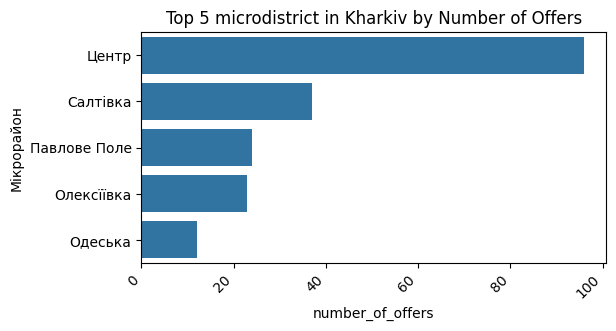

In [79]:
# also do the same thing with sub distinct
t5_df = df.groupby("Мікрорайон").size().reset_index(name="number_of_offers").sort_values(by="number_of_offers", ascending=False).head(5)

plt.figure(figsize=(6, 3))
sns.barplot(y="Мікрорайон", x="number_of_offers", data=t5_df)
plt.xticks(rotation=45, ha="right")
plt.title("Top 5 microdistrict in Kharkiv by Number of Offers")
plt.show()

## Second preprocessing

In [80]:
# let's see unique values for specific categorical data to see what exactly will be useful for future analysis
cat_columns = ["Тип стін", "Тип пропозиції", "Комісія", "Опалення", "Підігрів води", "Розташування", "Ліфт"]

for col in range(len(cat_columns)):
  if col != 0:
    print("\n")
  print(f"Unique_values from {cat_columns[col]}: {df[cat_columns[col]].unique()}")
  if col != (len(cat_columns)-1):
    print("\n")
    print("-"*100)

Unique_values from Тип стін: ['цегла' 'панель' nan 'монолітно-цегляний' 'монолітно-каркасний'
 'газоблок' 'керамічний блок' 'моноліт' 'силікатна цегла' 'газобетон'
 'монолітний залізобетон' 'керамзітобетон' 'піноблок' 'монолітно-блоковий']


----------------------------------------------------------------------------------------------------


Unique_values from Тип пропозиції: ['Пропозиція від власника' 'Пропозиція від посередника' nan]


----------------------------------------------------------------------------------------------------


Unique_values from Комісія: ['0' 'Комісія за послуги 50 %' 'Комісія за послуги 59 %'
 'Комісія за послуги 5 %' 'Комісія за послуги 30 %']


----------------------------------------------------------------------------------------------------


Unique_values from Опалення: [nan 'централізоване' 'автономна котельня' 'індивідуальне електричне'
 'централізоване|індивідуальне електричне'
 'індивідуальне газове|двоконтурний котел' 'індивідуальне газове'
 'д

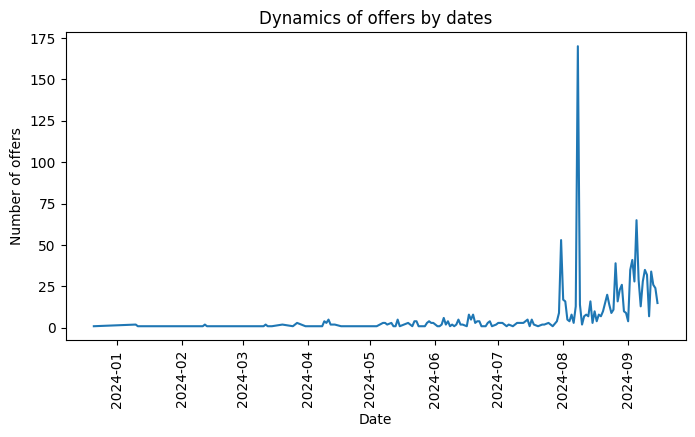

In [81]:
# wanna see how our date distribute by date
plt.figure(figsize=(8,4))
df_grouped = df.groupby(df["Дата"].dt.date).size().reset_index(name="number of offers")

plt.plot(df_grouped["Дата"], df_grouped["number of offers"])
plt.xticks(rotation=90)
plt.title("Dynamics of offers by dates")
plt.xlabel("Date")
plt.ylabel("Number of offers")

plt.show()

We see that there are more new current offers on the market, which is not surprising, because they have not yet been sold. So let's see how much data we lose if take only from may 2024 (
because the graph shows activity since that moment)

In [82]:
print(f'until summer 2024: {len(df[df["Дата"] < "2024-04-30"])}')
print(f'after summer 2024: {len(df[df["Дата"] > "2024-04-30"])}')

until summer 2024: 49
after summer 2024: 1186


In [83]:
df = df[df["Дата"] > "2024-04-30"]

also u can notice some of insane activity in one summer day. Let's see more detail

In [84]:
temp_df = df[df["Дата"] == "2024-08-08"]

pivot_table = pd.DataFrame({"factor": [], "name": [], "offers_num": []})

factors_cat = ["Назва ЖК", "Агенство", "Метро", "Вулиця"]
for col in factors_cat:
  sub = pd.DataFrame(temp_df.groupby(col).size().reset_index(name="number_of_offers").sort_values(by="number_of_offers", ascending=False).head(1))
  row_record = pd.DataFrame({"factor": [col], "name":[sub.iloc[0,0]], "offers_num": [sub.iloc[0,1]]})
  pivot_table = pd.concat([pivot_table, row_record], ignore_index=True)

pivot_table

factor                                name  offers_num
0  Назва ЖК                            ЖК Атолл         1.0
1  Агенство                             EstatyQ       155.0
2     Метро                             Наукова        15.0
3    Вулиця  просп. Героїв Харкова(Московський)         8.0

from that day there are 170 entries left, of which 155 are represented by one agency - EstatyQ

So, now I get some imagination how I can use this data to fill missing values in dataset and extract some more information.

In [85]:
# let's make second preprocessing stuff with data ( the bigger one)

df["zk_1"] = df["Назва ЖК"].apply(lambda x: 0 if pd.isna(x) else 1)
df["zk_2"] = df["Опис"].apply(lambda x: 1 if "жк" in str(x).lower() else 0)
df["metro_1"] = df['Метро'].apply(lambda x: 0 if pd.isna(x) else 1)
df["metro_2"] = df["Опис"].apply(lambda x: 1 if "метро" in str(x).lower() else 0)
df["Через агентство"] = df["Агенство"].apply(lambda x: 0 if pd.isna(x) else 1)
df["elevator_1"] = df["Ліфт"].apply(lambda x: 1 if "пасажирський ліфт" in str(x) \
                                   or "вантажний ліфт" in str(x) else 0)
df["elevator_2"] = df["Опис"].apply(lambda x: 1 if "ліфт" in str(x).lower() else 0)

values = ["тихий", "спокійний", "тихе", "тихій", "тихо", "спокійному", "спокійний", "спокійне", "найспокійніший"]
df["calm_distinct"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)

df["kitchen_studio_1"] = df["Планування"].apply(lambda x: 1 if "кухня-студія" in str(x) else 0)  # as a variant can add factor "підігрів підлоги"
df["kitchen_studio_2"] = df["Опис"].apply(lambda x: 1 if ("кухня-студія" in str(x).lower()) or ("кухня-студия" in str(x).lower()) else 0)

df["conditioner_1"] = df["Зручності"].apply(lambda x: 1 if "кондиціонер" in str(x) else 0)
df["conditioner_2"] = df["Опис"].apply(lambda x: 1 if ("кондиціонер" in str(x).lower()) or ("кондиціонування" in str(x).lower()) else 0)

values = ["бойлером", "бойлєр", "бойллер"]
boiler_regex = r'бойлер[^\w\d]'
df["boiler_1"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) or re.search(boiler_regex, str(x).lower()) else 0)
df["boiler_2"] = df["Підігрів води"].apply(lambda x: 1 if "бойлер" in str(x).lower() else 0)

# use simple imuter only for this factor, because for large amount of missing
# values we will use more advanced method
imputer = SimpleImputer(strategy='most_frequent')
df["Тип пропозиції"] = imputer.fit_transform(df[["Тип пропозиції"]]).ravel()

values = ["рост", "клас", "атб", "класс", "посад", "сільпо", "metro",
          "епіцентр", "чудо"]  # find the nearest hypermarkets
df["Поряд гіпермаркети"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)


df["fixed_apartment_1"] = df["Опис"].apply(lambda x: 1 if "ремонт" in str(x).lower() else 0)
df["fixed_apartment_2"] = df["Планування"].apply(lambda x: 1 if "з ремонтом" in str(x) else 0)

values = ["балкони", "лоджія", "балконом", "лоджію", "балконами",
          "балкончик", "балконы", "балконе"]
balcony_regex = r'балкон[^\w\d]'
df["balcony_1"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) or re.search(balcony_regex, str(x).lower()) else 0)
df["balcony_2"] = df["Планування"].apply(lambda x: 1 if ("балкон" in str(x)) or ("лоджія" in str(x)) else 0)

values = ["животным", "животными", "тваринами", "животное", "тварини",
          "твариною", "тваринками", "тваринки"]
df["pets_1"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)

values = ["центре", "центрі", "центральній", "центральной", "центра",
          "центру", "центральної"]
center_regex = r'центр[^\w\d]'
df["center_distinct"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) or re.search(center_regex, str(x).lower()) else 0)
df["center_distinct_1"] = df["Опис"].apply(lambda x: 1 if "центр" in str(x).lower() else 0)

values = ["саржин яр", "озеро", "озера", "річка", "річку", "річки", "річкою",
          "ліс", "лугопарк", "зоопарк", "лісопарк", "водохранилище",
          "водосховище", "водосховища"]
park_regex = r'парк[^\w\d]'
df["park_1"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) or re.search(park_regex, str(x).lower()) else 0)

df["park_2"] = df["Опис"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\b(?<!Ботанический\s)(?<!\b)сад(?!ик)\b', str(x)) else 0)


df["dishwasher_1"] = df["Зручності"].apply(lambda x: 1 if "посудомийна машина" in str(x) else 0)
values = ["посудомийна", "посудомоечная", "посудомийка", "посудомойка",
          "посудомоечной", "посудомийною", "посудомоечку", "посудомийну"]
df["dishwasher_2"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)


df["oven_1"] = df["Зручності"].apply(lambda x: 1 if "духова шафа" in str(x) else 0)
values = ["духова", "духовка", "духовой", "духовкой", "духовкою",
          "духовку", "духовою", "духовий", "духовник", "духової", "духовний"]
df["oven_2"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)

values = ["охорона", "охороняється", "охороною", "охоронювана", 'охоронна',
          "охорону", 'охоронного', "охорони", "охоронної", "охраной",
          "охраняемой", "охрана", "охраняемый", 'охраняемая', 'охранник',
          "сигналізація", "сигнализация", "сигналізації", "сигналізацією",
          "відеоспостереження", "відеонагляд", "відеонаглядом",
          "видеонаблюдение", "видеонаблюдением", "відеодомофон", "домофон"]
df["security_1"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)

values = ["паркінг", "паркувальне", "парковка", "парковочное",
          "паркинг", "парковки", "парковкою", "паркомісце", "паркомісця",
          "паркувальні", "паркова", "парковку", "паркувальних",
          "парковочными", "паркової", "паркові", "паркоместо",
          "парковочные", "паркуванням", "паркувати",
          "припарковать", "паркувальними", "парковочні", "парковаться",
          "парковая"]

df["Паркінг"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)

values = ["новострое", "новострой", "новобуд", "новостроя"]

df["Новобудова"] = df["Опис"].apply(lambda x: 1 if any(value in str(x).lower() for value in values) else 0)

def detect_specific_words(description):
    pattern = r'\b(студия|квартира-студия|студія|студію|квартиру-студію)\b'
    if re.search(pattern, str(description).lower()) and "кухня-студия" not in str(description).lower() and "кухня-студія" not in str(description).lower():
        return 1
    else:
        return 0

df["studio_1"] = df["Опис"].apply(detect_specific_words)


df["Ремонт"] = ((df["Новий ремонт"] == 1) | (df["fixed_apartment_1"] == 1) | (df["fixed_apartment_2"] == 1)).astype(int)
df["Охорона території"] = ((df["Територія охороняється"] == 1) | (df["security_1"] == 1)).astype(int)
df["ЖК"] = ((df["zk_1"] == 1) | (df["zk_2"] == 1)).astype(int)
df["Поряд метро"] = ((df["metro_1"] == 1) | (df["metro_2"] == 1) | (df["Поруч з метро"] == 1)).astype(int)
df["Спальний район"] = ((df["calm_distinct"] == 1) | (df["Спокійний район"] == 1) | (df["Тихий двір"] == 1)).astype(int)
df["Наявність ліфту"] = ((df["elevator_1"] == 1) | (df["elevator_2"] == 1)).astype(int)
df["Балкон"] = ((df["balcony_1"] == 1) | (df["balcony_2"] == 1)).astype(int)
df["Тварини"] = ((df["Можна з тваринами"] == 1) | (df["Тварини (опис)"] == 1) | (df["pets_1"] == 1)).astype(int)
df["Кухня студія"] = ((df["Кухня-студія"] == 1) | (df["kitchen_studio_1"] == 1) | (df["kitchen_studio_2"] == 1)).astype(int)
df["Центр"] = ((df["У центрі"] == 1) | (df["center_distinct"] == 1) | (df["center_distinct_1"] == 1)).astype(int)
df["Парк"] = ((df["park_1"] == 1) | (df["park_2"] == 1) | (df["Поруч з парком"] == 1)).astype(int)
df["Кондиціонер"] = ((df["conditioner_1"] == 1) | (df["conditioner_2"] == 1)).astype(int)
df["Бойлер"] = ((df["boiler_1"] == 1) | (df["boiler_2"] == 1)).astype(int)

df["Посудомийка"] = ((df["dishwasher_1"] == 1) | (df["dishwasher_2"] == 1)).astype(int)
df["Духовка"] = ((df["oven_1"] == 1) | (df["oven_2"] == 1)).astype(int)
df["Квартира студія"] = ((df["Студія"] == 1) | (df["studio_1"] == 1)).astype(int)

df.drop(columns=["Новий ремонт", "fixed_apartment_1", "fixed_apartment_2", "zk_1",
                 "zk_2", "metro_1", "metro_2", "Поруч з метро",
                 "calm_distinct", "Спокійний район", "Тихий двір", "elevator_1",
                 "elevator_2", "balcony_1", "balcony_2", "Планування",
                 "Приміщення", "Можна з тваринами", "Тварини (опис)",
                 "pets_1", "Кухня-студія", "kitchen_studio_1",
                 "kitchen_studio_2", "У центрі", "center_distinct",
                 "Поруч з парком", "park_1", "park_2", "Агенство",
                 "Ліфт", "Метро", "Назва ЖК", "Опалення",
                 "Розташування", "conditioner_1", "conditioner_2", "boiler_1",
                 "boiler_2", "Приміщення", "center_distinct_1",
                 "dishwasher_1", "dishwasher_2", "oven_1", "oven_2",
                 "Зручності", "Підігрів води", "security_1", "Територія охороняється",
                 "studio_1", "Студія", "Житлова площа"], inplace=True)

In [86]:
# for each distinct we have street name, so from that we can predict what distinct it is
df = df.dropna(subset="Широта")
df.reset_index(drop=True, inplace=True)
print(len(df[df["Район"].isna()]))
street_distinct = df.groupby("Вулиця")["Район"].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

def fill_missing_district(row, mode_by_street):
    if pd.isna(row["Район"]):
        return mode_by_street.get(row["Вулиця"], np.nan)
    else:
        return row["Район"]

df["Район"] = df.apply(lambda row: fill_missing_district(row, street_distinct), axis=1)
print(len(df[df["Район"].isna()]))

# for the rest of the data we will write down the values ​​manually
df.iloc[493, 2] = "Київський"
df.iloc[660, 2] = "Шевченківський"
df.iloc[694, 2] = "Немишлянський"
df.iloc[742, 2] = "Холодногірський"

print(len(df[df["Район"].isna()]))

31
4
0


<ipython-input-86-e5b67e1d640e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Район"] = df.apply(lambda row: fill_missing_district(row, street_distinct), axis=1)


In [87]:
# group the wall type based on similarity
def replace_wall_type(x):
  if pd.isna(x):
    return np.nan
  x = str(x).lower()
  if ("моноліт" in x) or ("монолітний залізобетон" in x) or ("монолітно-блоковий" in x) or ("монолітно-каркасний" in x) or ("монолітно-цегляний" in x):
    return "монолітні стіни"
  elif ("газобетон" in x) or ("газоблок" in x) or ("піноблок" in x) or ("керамзітобетон" in x) or ("керамічний блок" in x):
    return "блочні стіни"
  elif ("цегла" in x) or ("силікатна цегла" in x):
    return "цегляні стіни"
  else:
      return "панельні стіни"

df["Тип стін"] = df["Тип стін"].apply(replace_wall_type)
df.groupby("Тип стін").size().reset_index().rename(columns={0: "numebr_of_offers"})

Тип стін  numebr_of_offers
0     блочні стіни                19
1  монолітні стіни               106
2   панельні стіни               271
3    цегляні стіни               603

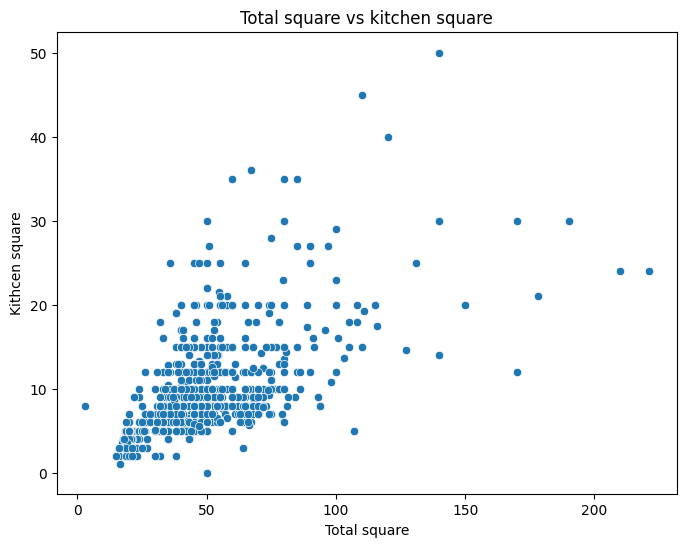

In [88]:
# we have some missing values in column "Площа кухні" and i wanna see how it depend on the total area
# best way to do that use plot
temp_data = df.copy()

temp_data = temp_data.dropna(subset="Площа кухні")

plt.figure(figsize=(8,6))
sns.scatterplot(data=temp_data, x="Загальна площа", y="Площа кухні")
plt.title("Total square vs kitchen square")
plt.xlabel("Total square")
plt.ylabel("Kithcen square")
plt.show()

we see that kithcen square in mostly depends on total square (almost linear)

Let's fill in only two columns ("Площа кухні" and "Тип стін") with the missing values. Because other columns have more missing values, the prediction of which may lead to multicolinearity with the factors that we will use to predict the price, as for example "Житлова площа" or "Опалення"

In [89]:
df.loc[df["Площа кухні"] == 0, "Площа кухні"] = np.nan

In [90]:
cols_with_nans = [x for x in df if df[x].isnull().sum()>0]
cols_with_nans = cols_with_nans[1:]

cols_banned = ["Ціна оренди (грн)", "Місто", "Вулиця", "Дата", "Комісія"]
parameters_for_impute = list(set(df.columns) - set(cols_with_nans) - set(cols_banned))

def filling_of_missing_values(df, factors, target, mode):
    categorical_data = df[factors].select_dtypes(include="O").columns
    data = df[factors].copy()

    if len(categorical_data) > 0:
        for col in categorical_data:
            if len(df[col].dropna().unique()) > 2:
                dummies = pd.get_dummies(df[col], prefix=col, dummy_na=False, dtype=float)
                data = pd.concat([data.drop(columns=col), dummies], axis=1)
            else:
                codes, uniques = pd.factorize(df[col])
                data[col] = codes

    if mode == "classifier" and df[target].dtype == "O":
      target_codes, target_uniques = pd.factorize(df[target])
      data[target] = target_codes
    else:
      data[target] = df[target]

    indx_nan = np.where(df[target].isna())[0]
    data["is_nan"] = 0
    data.loc[indx_nan, "is_nan"] = 1
    train = data[data["is_nan"] == 0]
    test = data[data["is_nan"] == 1]

    X_train = train.drop([target, "is_nan"], axis=1)
    y_train = train[target]
    X_test = test.drop([target, "is_nan"], axis=1)

    if mode == "regression":
      model = lgb.LGBMRegressor(verbose=-1)
    elif mode == "classifier":
      model = lgb.LGBMClassifier(verbose=-1)
    else:
      return "erorr model"

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if mode == "classifier" and df[target].dtype == "O":
      df.loc[indx_nan, target] = target_uniques[y_pred]
    else:
      df.loc[indx_nan, target] = y_pred

    return df

df = filling_of_missing_values(df, ["Загальна площа", "Кількість кімнат", "Поверх", "Всього поверхів"], "Площа кухні", "regression")
df = filling_of_missing_values(df, parameters_for_impute, "Тип стін", "classifier")

## Dealing with outliers

In [91]:
# let's check duplicates in dataset
df.duplicated().sum()

0

In [92]:
df.describe()

Ціна оренди (грн)  Загальна площа  Площа кухні       Поверх  \
count       1.151000e+03     1151.000000  1151.000000  1151.000000   
mean        8.796493e+03       48.580539     9.477089     5.851434   
min         1.700000e+03        3.000000     1.000000     0.000000   
25%         4.000000e+03       33.000000     6.000000     3.000000   
50%         6.000000e+03       45.000000     8.000000     5.000000   
75%         9.000000e+03       56.650000    11.000000     8.000000   
max         1.323200e+06      221.000000    50.000000    25.000000   
std         3.962397e+04       23.357227     5.445436     3.953820   

       Всього поверхів  Кількість кімнат  Кількість фото       Широта  \
count       1151.00000       1151.000000     1151.000000  1151.000000   
mean           9.82450          1.665508       11.083406    49.936064   
min            1.00000          1.000000        3.000000    36.283781   
25%            6.00000          1.000000        7.000000    49.987750   
50%            9.00000          1.000000       10.000000    50.011627   
75%           12.00000          2.000000       13.000000    50.025119   
max           25.00000          5.000000       58.000000    50.088704   
std            4.82192          0.795761        5.504622     0.987097   

           Довгота                           Дата  ...       Балкон  \
count  1151.000000                           1151  ...  1151.000000   
mean     36.339639  2024-08-12 22:53:41.546481152  ...     0.314509   
min      36.137752            2024-05-01 00:00:00  ...     0.000000   
25%      36.217840            2024-08-04 12:00:00  ...     0.000000   
50%      36.246352            2024-08-22 00:00:00  ...     0.000000   
75%      36.326971            2024-09-05 00:00:00  ...     1.000000   
max      50.025941            2024-09-15 00:00:00  ...     1.000000   
std       0.992205                            NaN  ...     0.464522   

           Тварини  Кухня студія        Центр         Парк  Кондиціонер  \
count  1151.000000   1151.000000  1151.000000  1151.000000  1151.000000   
mean      0.132059      0.069505     0.242398     0.172893     0.274544   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       0.000000      0.000000     0.000000     0.000000     0.000000   
75%       0.000000      0.000000     0.000000     0.000000     1.000000   
max       1.000000      1.000000     1.000000     1.000000     1.000000   
std       0.338702      0.254421     0.428720     0.378319     0.446478   

            Бойлер  Посудомийка      Духовка  Квартира студія  
count  1151.000000  1151.000000  1151.000000      1151.000000  
mean      0.318853     0.069505     0.205039         0.081668  
min       0.000000     0.000000     0.000000         0.000000  
25%       0.000000     0.000000     0.000000         0.000000  
50%       0.000000     0.000000     0.000000         0.000000  
75%       1.000000     0.000000     0.000000         0.000000  
max       1.000000     1.000000     1.000000         1.000000  
std       0.466235     0.254421     0.403906         0.273977  

[8 rows x 32 columns]

In [93]:
# as we can see from overall statistic max price value is 1.323200e+06
# I think it's a little expensive to rent, because we have value of 75% - 9000
df = df[df["Ціна оренди (грн)"] < df["Ціна оренди (грн)"].max()]

In [94]:
# also remove where kitchen square > total square
df = df[~(df["Загальна площа"] < df["Площа кухні"])]

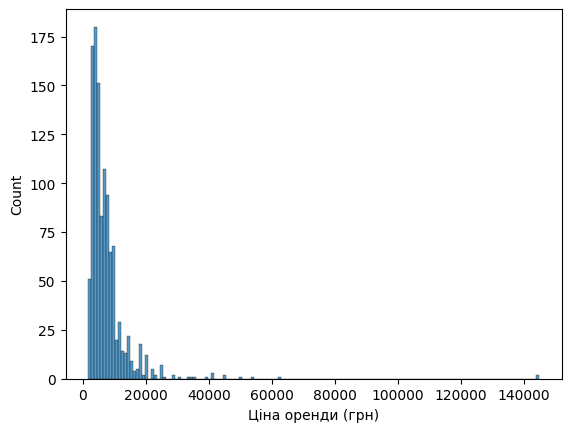

In [95]:
# if we look more detail on rent price distribution we can see that we still have outliers on the right
sns.histplot(data=df, x="Ціна оренди (грн)")
plt.show()

even after that we observe left skewness, that isn't very good for analysis and modeling. So in this situation we should remove outliers for better understanding the overall market conditions. Of course, outliers removing it is kind of bad, because we lose valuable information about market specific, but our main goal to understand main significant market specific and build ML model for common use.

In [96]:
# let's custom remove outliers using Percentile approach
# we will cut the price more and the total area and kitchen area will be smaller
lower_border = df['Ціна оренди (грн)'].quantile(0.01)
upper_border = df['Ціна оренди (грн)'].quantile(0.97)

lower_border_ts = df['Загальна площа'].quantile(0.01)
upper_border_ts = df['Загальна площа'].quantile(0.99)

lower_border_ks = df['Площа кухні'].quantile(0.01)
upper_border_ks = df['Площа кухні'].quantile(0.99)

df = df[(df['Ціна оренди (грн)'] < upper_border) &
 (df['Ціна оренди (грн)'] > lower_border) &
  (df['Загальна площа'] < upper_border_ts) &
  (df['Загальна площа'] > lower_border_ts) &
   (df['Площа кухні'] < upper_border_ks) &
    (df['Площа кухні'] > lower_border_ks)]

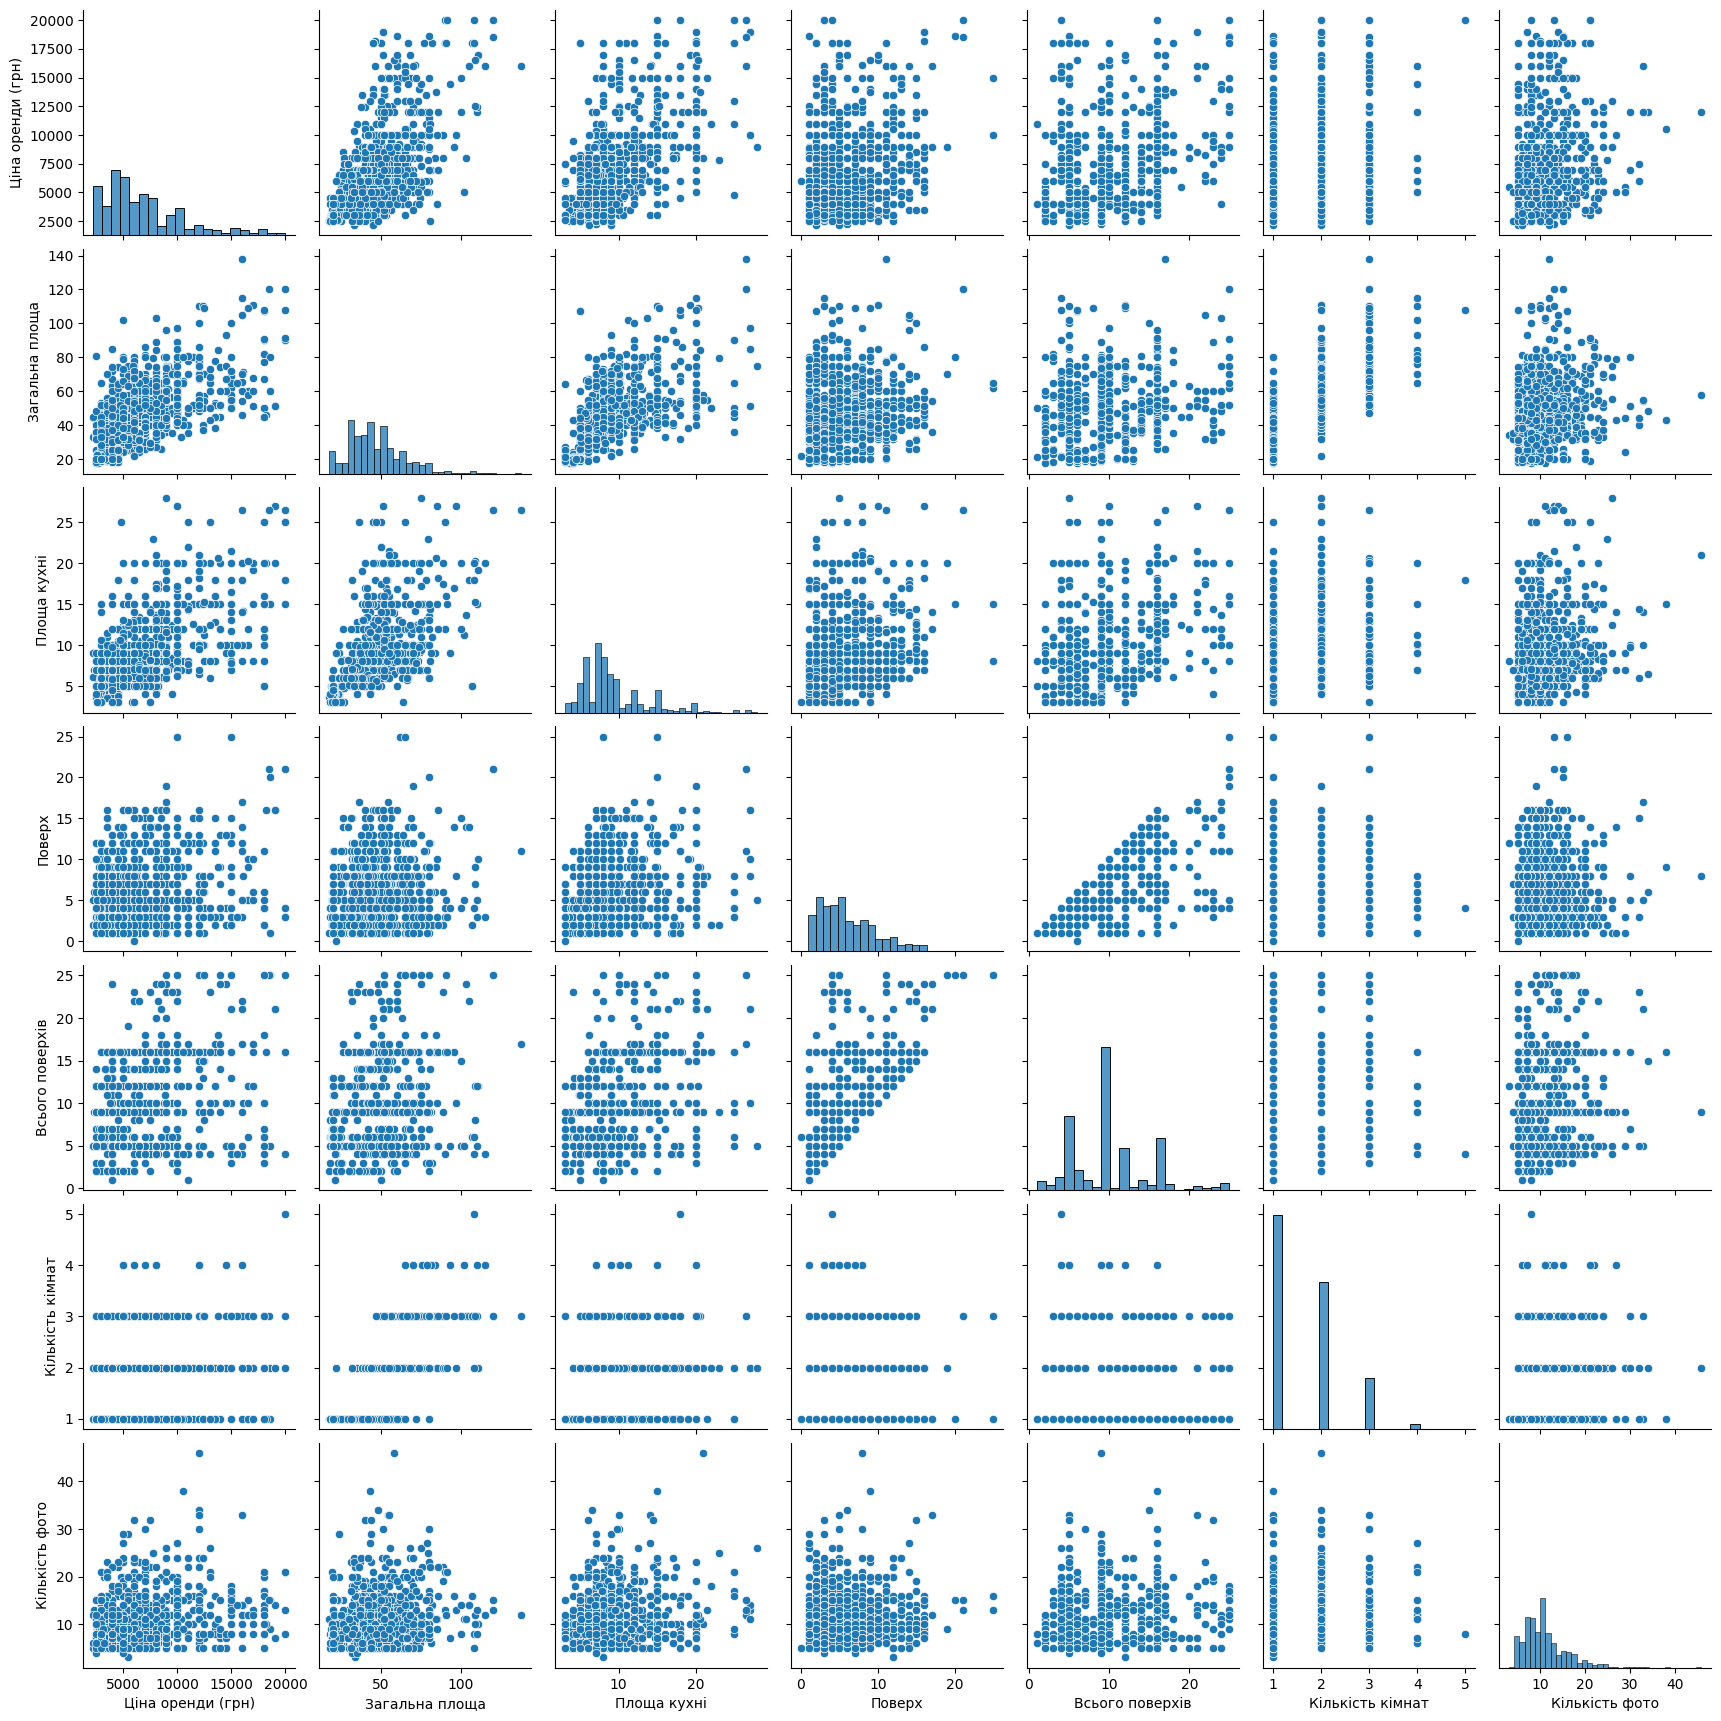

In [97]:
# let's make paiplot, but without binary categorical data for ease of perception
test_data = df[["Ціна оренди (грн)", "Загальна площа","Площа кухні", "Поверх",
                "Всього поверхів", "Кількість кімнат", "Кількість фото"]]
sns.pairplot(test_data)
plt.show()

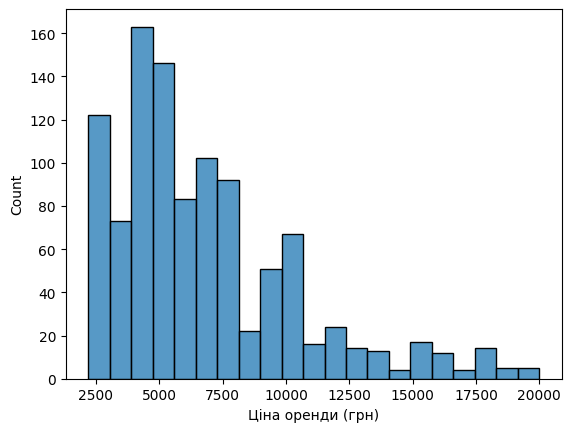

In [98]:
# if we look more detail on rent price distribution we can see that we still have outliers on the right
sns.histplot(data=df, x="Ціна оренди (грн)")
plt.show()

as you can see result much better, but still hard to say that price have normal distribution. However, such a distribution should still give the best result when modeling it.

In [100]:
# and let's see how many data we lost by removing outliers
1151 - df.shape[0] # almost 9% that is huge amount of data for our small dataset, but we have no choice

102

In [101]:
# let's see overall statistic again after removing outliers
df.describe()

Ціна оренди (грн)  Загальна площа  Площа кухні       Поверх  \
count        1049.000000      1049.00000  1049.000000  1049.000000   
mean         6779.380362        47.04652     9.163584     5.865586   
min          2200.000000        17.30000     3.000000     0.000000   
25%          4000.000000        34.00000     6.126973     3.000000   
50%          6000.000000        45.00000     8.000000     5.000000   
75%          8500.000000        55.00000    10.200000     8.000000   
max         20000.000000       138.00000    28.000000    25.000000   
std          3614.825305        17.59797     4.236935     3.919520   

       Всього поверхів  Кількість кімнат  Кількість фото       Широта  \
count      1049.000000       1049.000000     1049.000000  1049.000000   
mean          9.865586          1.635844       10.930410    49.929847   
min           1.000000          1.000000        3.000000    36.283781   
25%           6.000000          1.000000        7.000000    49.987696   
50%           9.000000          1.000000       10.000000    50.011750   
75%          12.000000          2.000000       13.000000    50.025735   
max          25.000000          5.000000       46.000000    50.088704   
std           4.742214          0.747063        5.003998     1.033774   

           Довгота                           Дата  ...       Балкон  \
count  1049.000000                           1049  ...  1049.000000   
mean     36.346115  2024-08-13 12:37:45.014299392  ...     0.313632   
min      36.137752            2024-05-01 00:00:00  ...     0.000000   
25%      36.217380            2024-08-05 00:00:00  ...     0.000000   
50%      36.245639            2024-08-22 00:00:00  ...     0.000000   
75%      36.327427            2024-09-05 00:00:00  ...     1.000000   
max      50.025941            2024-09-15 00:00:00  ...     1.000000   
std       1.038978                            NaN  ...     0.464190   

           Тварини  Кухня студія        Центр         Парк  Кондиціонер  \
count  1049.000000   1049.000000  1049.000000  1049.000000  1049.000000   
mean      0.129647      0.062917     0.235462     0.176358     0.269781   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       0.000000      0.000000     0.000000     0.000000     0.000000   
75%       0.000000      0.000000     0.000000     0.000000     1.000000   
max       1.000000      1.000000     1.000000     1.000000     1.000000   
std       0.336075      0.242930     0.424490     0.381307     0.444058   

            Бойлер  Посудомийка      Духовка  Квартира студія  
count  1049.000000  1049.000000  1049.000000      1049.000000  
mean      0.322212     0.061010     0.207817         0.076263  
min       0.000000     0.000000     0.000000         0.000000  
25%       0.000000     0.000000     0.000000         0.000000  
50%       0.000000     0.000000     0.000000         0.000000  
75%       1.000000     0.000000     0.000000         0.000000  
max       1.000000     1.000000     1.000000         1.000000  
std       0.467546     0.239464     0.405939         0.265545  

[8 rows x 32 columns]

# Data visualization

In [102]:
# let's see apartment distribution on the city map
mean_price = df["Ціна оренди (грн)"].mean()
kharkiv_map = folium.Map(location=[49.9935, 36.2304], zoom_start=12)

for idx, row in df[["Широта", "Довгота", "Ціна оренди (грн)"]].dropna().iterrows():
    color = "red" if row["Ціна оренди (грн)"] > mean_price else "blue"
    folium.Marker([row["Широта"], row["Довгота"]],
                  popup=f"House {idx}, Price: {row['Ціна оренди (грн)']}",
                  icon=folium.Icon(color=color)).add_to(kharkiv_map)

kharkiv_map

In [103]:
# let's check apartment distribution by city areas and other price statistic
df.groupby("Район")["Ціна оренди (грн)"].agg(["count", "mean",
                                              "median", "max","min"]).reset_index().sort_values(by='mean', ascending=False)

Район  count         mean  median      max     min
4    Основ’янський     51  8690.196078  8000.0  18200.0  3500.0
8   Шевченківський    393  8202.671756  7000.0  20000.0  2200.0
3   Новобаварський     28  7949.035714  7000.0  18000.0  4000.0
7  Холодногірський     57  7360.789474  7000.0  16065.0  2500.0
6      Слобідський     65  6227.692308  5000.0  16500.0  2500.0
1        Київський    158  5809.930380  5000.0  18000.0  2300.0
2    Немишлянський     44  5605.431818  5000.0  13000.0  2600.0
0   Індустріальний     35  5199.971429  5000.0  10000.0  2500.0
5      Салтівський    218  4821.903670  4000.0  10500.0  2200.0

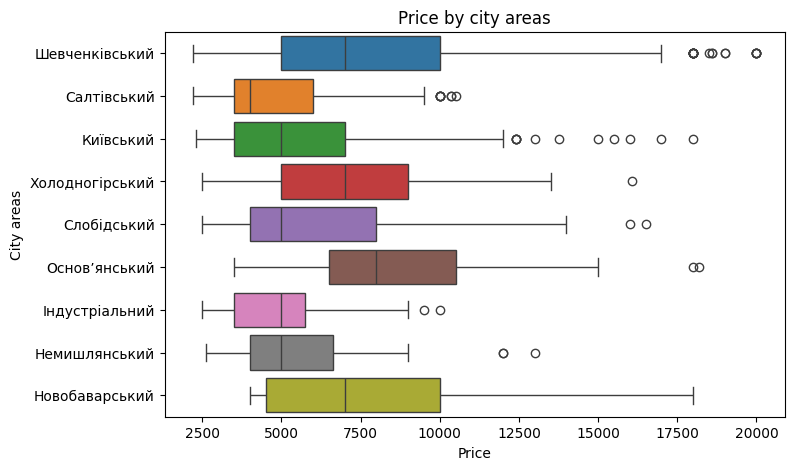

In [104]:
# best way to see apartment distribution on the graph
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, y="Район", x="Ціна оренди (грн)", hue="Район")

plt.title("Price by city areas")
plt.xlabel("Price")
plt.ylabel("City areas")

plt.show()

As we see, there is a difference between the groups, but it’s hard to say that it is very significant, but we can try to use it for our modeling.

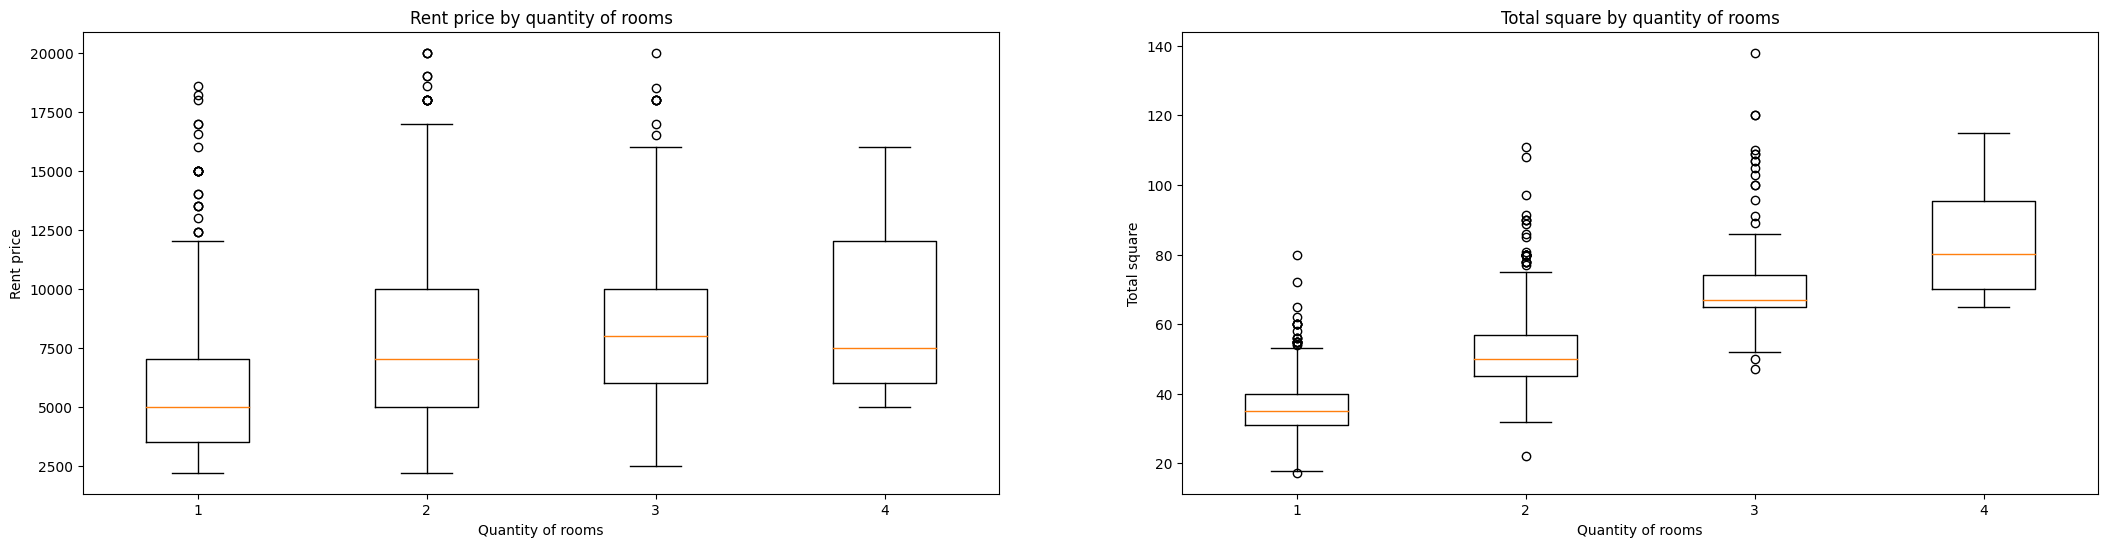

In [105]:
# let's check rent price and total square distributions by room quantity

df = df[~(df["Кількість кімнат"] == 5)]
f, ax = plt.subplots(1, 2, figsize=(26, 6))

ax[0].boxplot([df[df["Кількість кімнат"] == rooms]["Ціна оренди (грн)"] for rooms in sorted(df["Кількість кімнат"].unique())],
              labels=sorted(df["Кількість кімнат"].unique()))
ax[0].set_title("Rent price by quantity of rooms")
ax[0].set_xlabel("Quantity of rooms")
ax[0].set_ylabel("Rent price")

ax[1].boxplot([df[df["Кількість кімнат"] == rooms]["Загальна площа"] for rooms in sorted(df["Кількість кімнат"].unique())],
              labels=sorted(df["Кількість кімнат"].unique()))
ax[1].set_title("Total square by quantity of rooms")
ax[1].set_xlabel("Quantity of rooms")
ax[1].set_ylabel("Total square")

plt.show()

on this graph we see that rent price of 1 room apartment the same like 2 room or 3 room, so that stat is insane. So let's see more detail this situation.

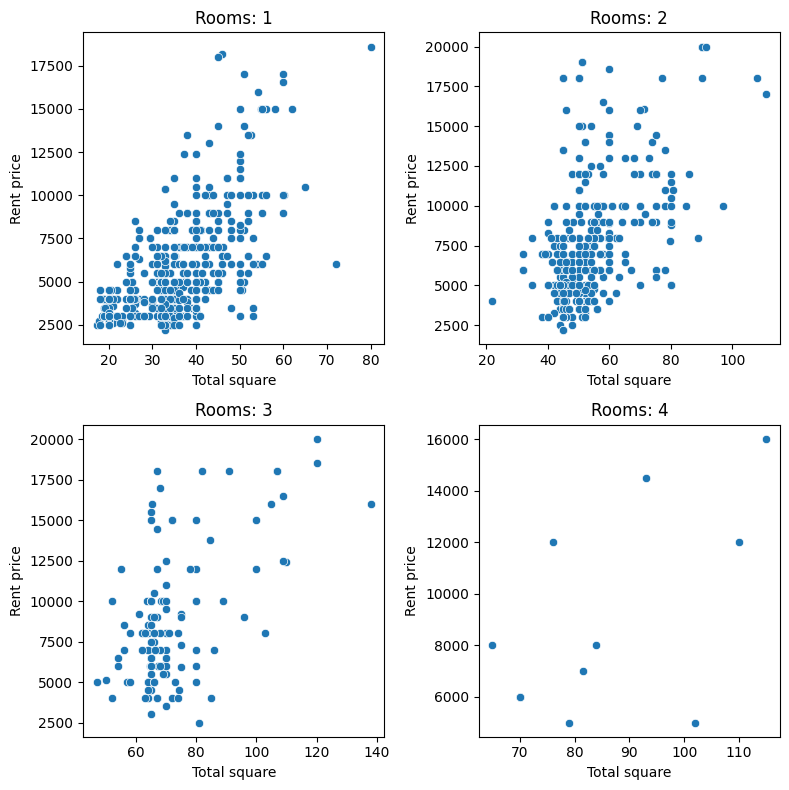

In [106]:
# also can use for this graph building FacetGrid

unique_rooms = sorted(list(df["Кількість кімнат"].unique()))

num_plots = len(unique_rooms)
ncols = 2
nrows = (num_plots // ncols) + (num_plots % ncols > 0)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

axes = axes.flatten()

# build graph by each room
for i, rooms in enumerate(unique_rooms):
    ax = axes[i]
    subset = df[df["Кількість кімнат"] == rooms]
    sns.scatterplot(data=subset, x="Загальна площа", y="Ціна оренди (грн)", ax=ax)
    ax.set_title(f'Rooms: {rooms}')
    ax.set_xlabel("Total square")
    ax.set_ylabel("Rent price")

plt.tight_layout()
plt.show()

As we see, there is a really interesting situation in which the price of renting a 1 room apartment is more than a 4 room apartment, and this is not an isolated outlier. Perhaps the rental price for a three-room apartment is lower because there is simply less interest in it as such in today's circumstances.

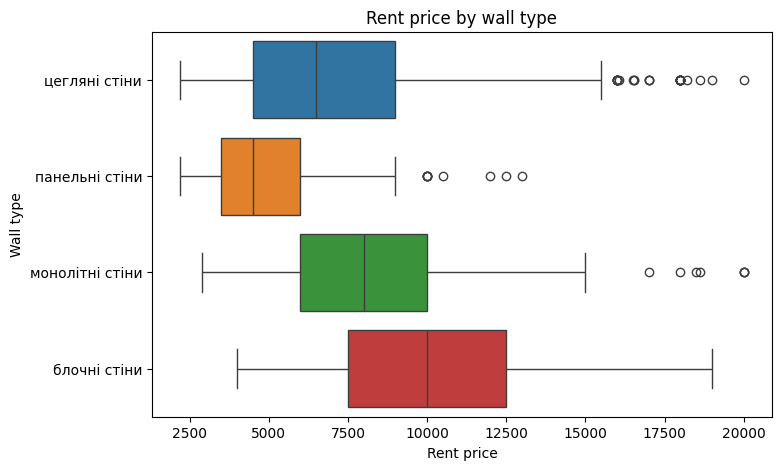

In [107]:
# let's see rent price distribution by wall type on the graph
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, y="Тип стін", x="Ціна оренди (грн)", hue="Тип стін")

plt.title("Rent price by wall type")
plt.xlabel("Rent price")
plt.ylabel("Wall type")

plt.show()

wall type can be our predictor for modeling rent price prediction, because the differences are significant, even if there are a couple of outliers on the boxplot.

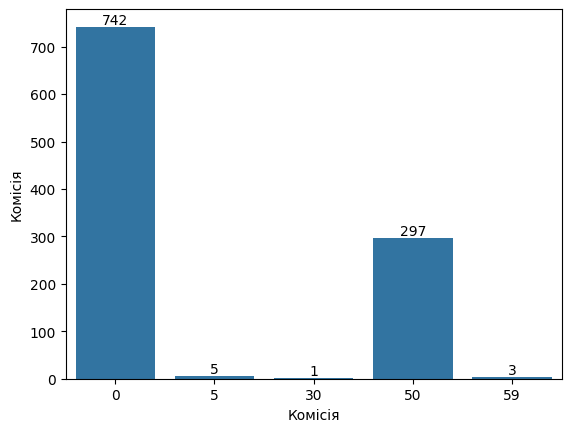

In [108]:
def extract_percentage(value):
    if value == '0':
        return 0
    else:
        return int(''.join(filter(str.isdigit, value)))

df["Комісія"] = df["Комісія"].apply(extract_percentage)

ax = sns.barplot(df, x="Комісія", y="Комісія", estimator="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);

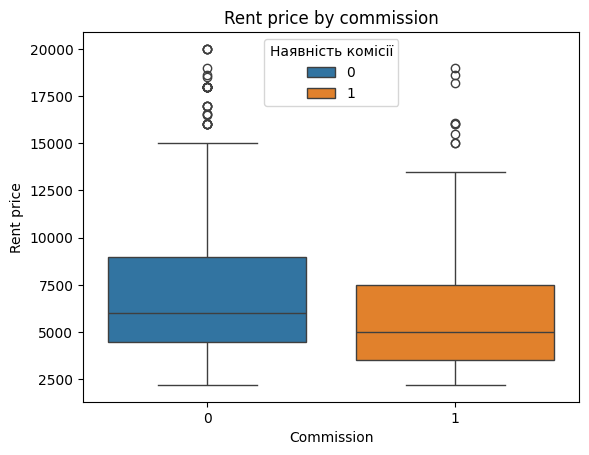

In [109]:
df["Наявність комісії"] = df["Комісія"].apply(lambda x: 1 if x != 0 else 0)

sns.boxplot(data=df, x="Наявність комісії", y="Ціна оренди (грн)", hue="Наявність комісії")

plt.title("Rent price by commission")
plt.xlabel("Commission")
plt.ylabel("Rent price")

plt.show()

Since we see that the price distributions between visibility of the commission, so we can say that this variable is not really significant but can try this predictor of price.

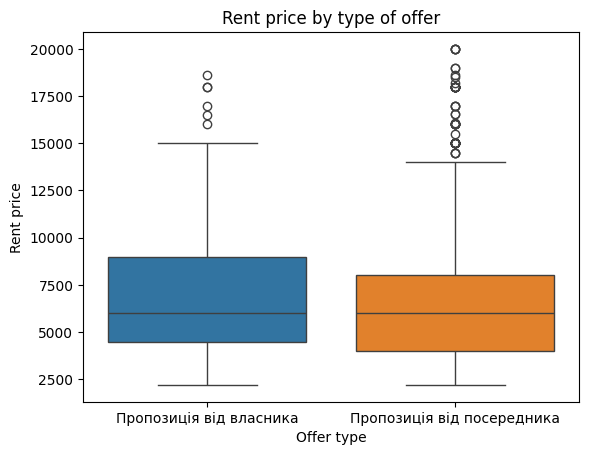

In [110]:
sns.boxplot(data=df, x="Тип пропозиції", y="Ціна оренди (грн)", hue="Тип пропозиції")
plt.title("Rent price by type of offer")
plt.xlabel("Offer type")
plt.ylabel("Rent price")

plt.show()

Also not really good factor as rent price predictor

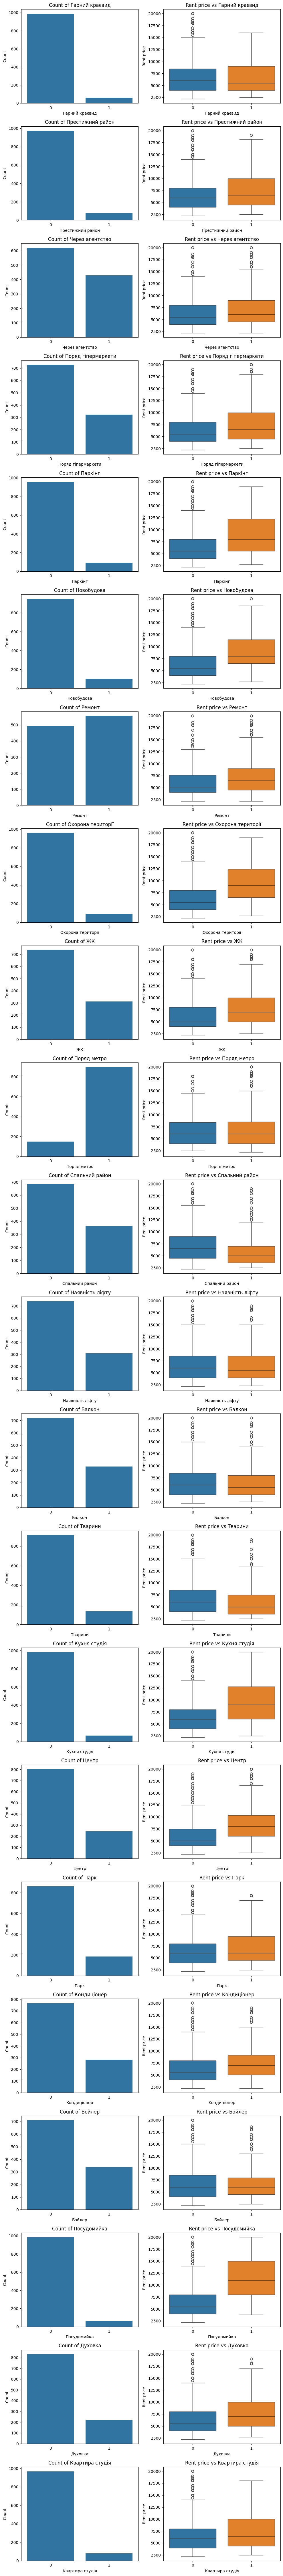

In [112]:
# let's deal with other categorical factors
categorical_data = ["Гарний краєвид", "Престижний район", "Через агентство",
                    "Поряд гіпермаркети", "Паркінг", "Новобудова", "Ремонт",
                    "Охорона території", "ЖК", "Поряд метро", "Спальний район",
                    "Наявність ліфту", "Балкон", "Тварини", "Кухня студія",
                    "Центр", "Парк", "Кондиціонер", "Бойлер", "Посудомийка",
                    "Духовка", "Квартира студія"]

fig, axes = plt.subplots(len(categorical_data), 2, figsize=(10, 90))

for i, cat_var in enumerate(categorical_data):
  sns.countplot(data=df, x=cat_var, ax=axes[i, 0])

  sns.boxplot(data=df, x=cat_var, y="Ціна оренди (грн)", hue=cat_var, ax=axes[i, 1])

  axes[i, 1].legend_.remove()

  axes[i, 0].set_xlabel(cat_var)
  axes[i, 0].set_ylabel("Count")
  axes[i, 0].set_title(f"Count of {cat_var}")

  axes[i, 1].set_xlabel(cat_var)
  axes[i, 1].set_ylabel("Rent price")
  axes[i, 1].set_title(f"Rent price vs {cat_var}")

plt.tight_layout()
plt.show()

And so, we can identify factors such as ("Поряд гіпермаркети", "Паркінг", "Новобудова", "Ремонт", "Охорона території", "ЖК", "Спальний район", "Тварини", "Кухня-студія", "Центр", "Кондиціонер", Посудомийка, "Духовка") that can be predictors for the rental price

## Correlation matrix

<Axes: >

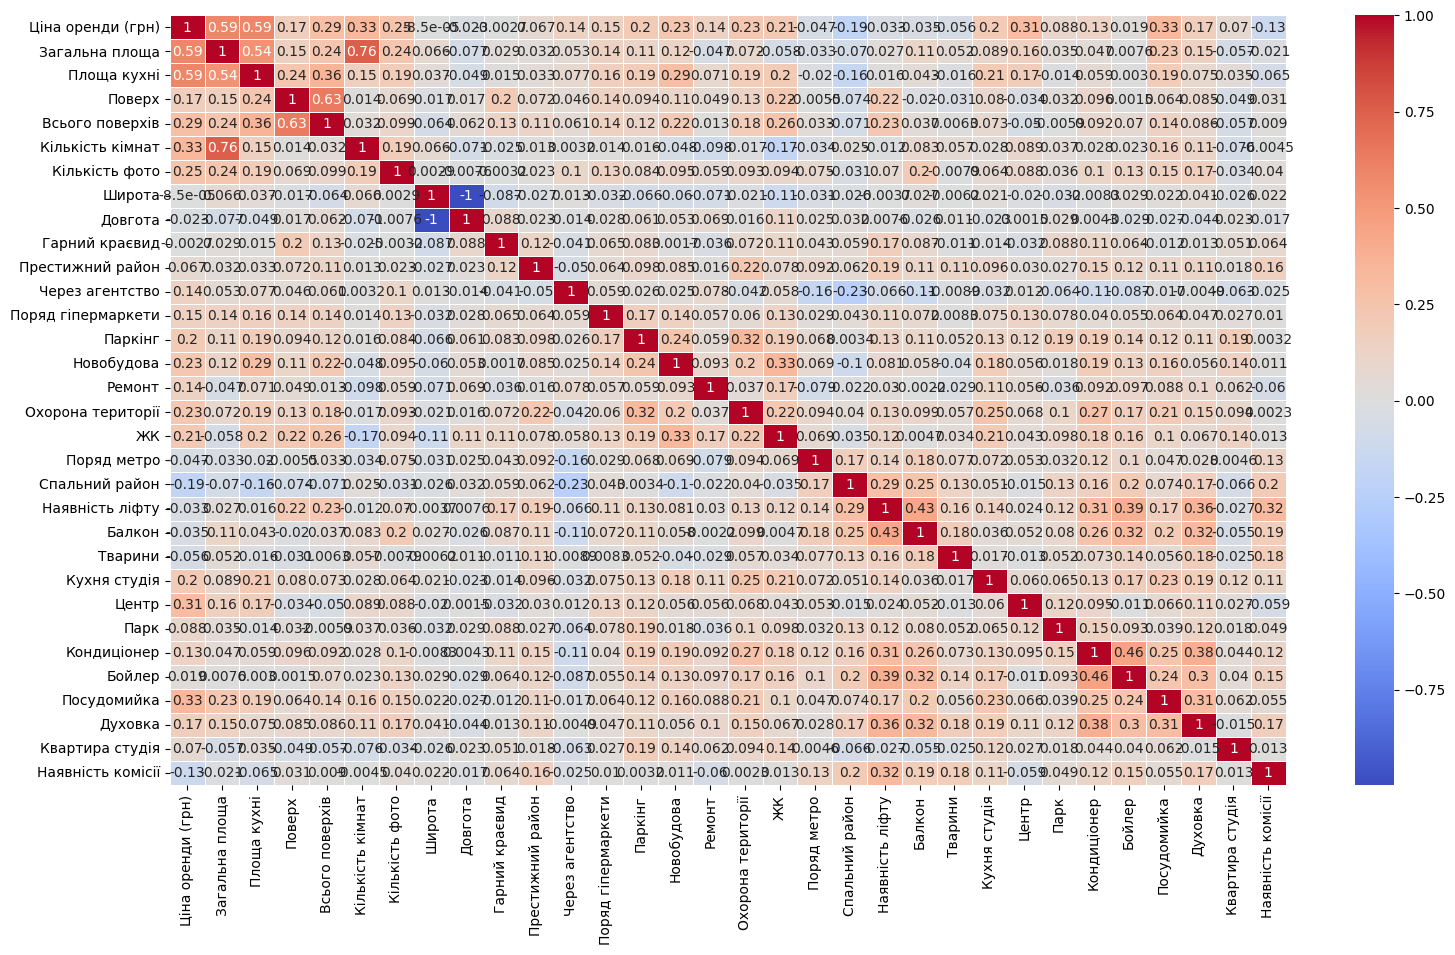

In [113]:
# let's see correlation matrix between only numerical factors
corr_matrix = df[["Ціна оренди (грн)",
       "Загальна площа", "Площа кухні", "Поверх",
       "Всього поверхів", "Кількість кімнат", "Кількість фото",
       "Широта", "Довгота", "Гарний краєвид", "Престижний район",
       "Через агентство", "Поряд гіпермаркети", "Паркінг",
       "Новобудова", "Ремонт", "Охорона території", "ЖК", "Поряд метро",
       "Спальний район", "Наявність ліфту", "Балкон", "Тварини",
       "Кухня студія", "Центр", "Парк", "Кондиціонер", "Бойлер", "Посудомийка",
       "Духовка", "Квартира студія", "Наявність комісії"]].corr()
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

We can also note the multicollinearity of such factors as the total area and number of rooms, but it less than 0.8 so ignore that. So let's choose factors for the modeling.

# Final preprocessing for further modeling

In [114]:
backup_df = df.copy()

In [115]:
# prepare categorical data and remove unnecessary data
df.drop(columns=["Місто", "Мікрорайон", "Вулиця", "Комісія", "Опис",
                 "Тип пропозиції", "Гарний краєвид",
                 "Престижний район", "Поряд метро",
                 "Наявність ліфту", "Балкон", "Тварини", "Парк",
                 "Квартира студія", "Бойлер"], inplace=True)
categorical_columns = ["Район", "Тип стін"]
dummies = pd.get_dummies(df[categorical_columns], dtype=float)
processed_data = pd.concat([df.drop(columns=categorical_columns), dummies], axis=1) # drop_first=True
# processed_data["Тип пропозиції"] = pd.factorize(df["Тип пропозиції"])[0]
processed_data.head()

Ціна оренди (грн) Номер будинку  Загальна площа  Площа кухні  Поверх  \
0             9000.0            13            40.0     8.508848       9   
1             8000.0           195            84.0     9.000000       6   
2             7000.0            19            44.0    12.000000       8   
3             4500.0           53Б            42.0    10.500000       5   
4             2500.0           18Б            17.3     3.700000       1   

   Всього поверхів  Кількість кімнат  Кількість фото     Широта    Довгота  \
0                9                 1              12  50.072799  36.209929   
1               16                 4              11  50.016135  36.214277   
2               12                 1               7  50.016165  36.206896   
3                9                 1              12  50.057361  36.194628   
4                2                 1              11  49.986232  36.302292   

   ... Район_Новобаварський  Район_Основ’янський  Район_Салтівський  \
0  ...                  0.0                  0.0                0.0   
1  ...                  0.0                  0.0                0.0   
2  ...                  0.0                  0.0                0.0   
3  ...                  0.0                  0.0                0.0   
4  ...                  0.0                  0.0                1.0   

   Район_Слобідський  Район_Холодногірський  Район_Шевченківський  \
0                0.0                    0.0                   1.0   
1                0.0                    0.0                   1.0   
2                0.0                    0.0                   1.0   
3                0.0                    0.0                   1.0   
4                0.0                    0.0                   0.0   

   Тип стін_блочні стіни  Тип стін_монолітні стіни  Тип стін_панельні стіни  \
0                    0.0                       0.0                      0.0   
1                    0.0                       0.0                      1.0   
2                    0.0                       0.0                      0.0   
3                    0.0                       0.0                      0.0   
4                    0.0                       0.0                      0.0   

   Тип стін_цегляні стіни  
0                     1.0  
1                     0.0  
2                     1.0  
3                     1.0  
4                     1.0  

[5 rows x 38 columns]

## Modeling

In [138]:
# split data
y = processed_data['Ціна оренди (грн)']
X = processed_data[['Загальна площа', 'Площа кухні',
       'Всього поверхів', 'Кількість фото',
       'Через агентство', 'Поряд гіпермаркети', 'Паркінг', 'Новобудова',
       'Ремонт', 'Охорона території', 'ЖК', 'Спальний район', 'Кухня студія',
       'Центр', 'Кондиціонер', 'Посудомийка', 'Духовка', 'Наявність комісії',
       'Район_Індустріальний', 'Район_Київський', 'Район_Немишлянський',
       'Район_Новобаварський', 'Район_Основ’янський', 'Район_Салтівський',
       'Район_Слобідський', 'Район_Холодногірський', 'Район_Шевченківський',
       'Тип стін_блочні стіни', 'Тип стін_монолітні стіни',
       'Тип стін_панельні стіни', 'Тип стін_цегляні стіни']]

In [139]:
X.shape[0]

1048

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(890, 31)
(890,)
(158, 31)
(158,)


In [141]:
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

In [148]:
random_state = 42

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=random_state),
    'Random Forest': RandomForestRegressor(random_state=random_state),
    'SVR': SVR(),
    'LightGBM': lgb.LGBMRegressor(verbose=-1),
    'XGBoost': xgb.XGBRegressor(random_state=random_state),
    'Gradient Boosting Regressor' : GradientBoostingRegressor(random_state=random_state),
    'ADA Boost' : AdaBoostRegressor(random_state=random_state),
    'Linear SVR' : LinearSVR(random_state=random_state),
}

evaluation_df = pd.DataFrame({
    'Model': [],
    'MSE': [],
    'MAE': [],
    'R-squared': [],
    'R-squared-for_train': [],
    'MAE train': []
})

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()

    pred = model.predict(X_test)
    pred_train = model.predict(X_train)

    training_time = end_time - start_time
    print(f"{name} training is finished")
    print(f"Spended time - {training_time}")
    print("~"*20)
    print("\n")

    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r_squared = r2_score(y_test, pred)
    r_squared_train = r2_score(y_train, pred_train)
    mae_train = mean_absolute_error(y_train, pred_train)

    new_row = pd.DataFrame({
        'Model': [name],
        'MSE': [mse],
        'MAE': [mae],
        'R-squared': [r_squared],
        'R-squared-for_train': [r_squared_train],
        'MAE train': [mae_train]
    })

    evaluation_df = pd.concat([evaluation_df, new_row], ignore_index=True)

Linear Regression training is finished
Spended time - 0.10004043579101562
~~~~~~~~~~~~~~~~~~~~


Decision Tree training is finished
Spended time - 0.03806614875793457
~~~~~~~~~~~~~~~~~~~~


Random Forest training is finished
Spended time - 1.2920029163360596
~~~~~~~~~~~~~~~~~~~~


SVR training is finished
Spended time - 0.20804047584533691
~~~~~~~~~~~~~~~~~~~~


LightGBM training is finished
Spended time - 0.12764430046081543
~~~~~~~~~~~~~~~~~~~~


XGBoost training is finished
Spended time - 5.229263067245483
~~~~~~~~~~~~~~~~~~~~


Gradient Boosting Regressor training is finished
Spended time - 0.29648733139038086
~~~~~~~~~~~~~~~~~~~~


ADA Boost training is finished
Spended time - 0.09607720375061035
~~~~~~~~~~~~~~~~~~~~


Linear SVR training is finished
Spended time - 0.00537562370300293
~~~~~~~~~~~~~~~~~~~~




In [149]:
# let's see what we get
evaluation_df.sort_values(by='MSE', ascending=True)

Model           MSE          MAE  R-squared  \
2                Random Forest  4.580877e+06  1606.498774   0.656982   
6  Gradient Boosting Regressor  4.600255e+06  1614.994836   0.655531   
5                      XGBoost  4.998876e+06  1651.411482   0.625682   
0            Linear Regression  5.073431e+06  1760.128605   0.620100   
4                     LightGBM  5.484095e+06  1762.343387   0.589349   
7                    ADA Boost  5.837516e+06  1944.490796   0.562885   
8                   Linear SVR  6.614721e+06  1912.023910   0.504687   
1                Decision Tree  1.056401e+07  2153.120253   0.208963   
3                          SVR  1.390981e+07  2731.858771  -0.041571   

   R-squared-for_train    MAE train  
2             0.939496   609.896002  
6             0.791420  1208.242116  
5             0.996107   138.401950  
0             0.609799  1654.760582  
4             0.915263   732.378977  
7             0.555730  1930.883255  
8             0.455706  1895.603614  
1             0.999684     4.239326  
3            -0.037534  2614.980070

As we can see the best model here is Random Forest and also we can notice that this model are overfitting, because we have really good metrics on train data and not good on test data. And to solve this problem, you need to either add data or remove some features so that the non-existent connection disappears. Or for example, we can tune regularization on XGBoost model.

# Cross validation

In [150]:
# ok, first of all let's try cross validation for Random Forest and see what mean metrics we have

best_model = RandomForestRegressor()

kf = KFold(n_splits=10, shuffle=True, random_state=42)

kf_score_r2 = cross_val_score(best_model, X, y, cv=kf, scoring="r2")
kf_score_mae = cross_val_score(best_model, X, y, cv=kf, scoring="neg_mean_absolute_error")

print(f"Cross validation average R2 score: {np.average(kf_score_r2)}")
print(f"Cross validation average MAE score : {np.abs(np.average(kf_score_mae))}")

Cross validation average R2 score: 0.5967004028035774
Cross validation average MAE score : 1607.9034023255713


as we see final result much worst than we thought

# XGBoost tuning and regularization

In [152]:
xgboost_model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'alpha': [0, 0.5, 1],
    'lambda': [1, 1.5, 2]
}

grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 score: {r2}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'alpha': 0, 'colsample_bytree': 1.0, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.7}
Mean Squared Error: 4463633.622977945
R2 score: 0.6657614674096606


In [155]:
y_pred_tun = best_model.predict(X_test)

# Evaluate the best model on the test set
mse_tun = mean_squared_error(y_test, y_pred_tun)
print(f"Mean Squared Error of the best model: {mse_tun}")
mae_tun = mean_absolute_error(y_test, y_pred_tun)
print(f"Mean Absolute Error of the best model: {mae_tun}")
r2_tun = r2_score(y_test, y_pred_tun)
print(f"R2 of the best model: {r2_tun}")

Mean Squared Error of the best model: 4463633.622977945
Mean Absolute Error of the best model: 1569.5206422443632
R2 of the best model: 0.6657614674096606


Finally we can improve model a little and the reason why the model doesn't work out very well is the quality of the collected data. Well, another option is to say that the rental real-estate market is quite difficult to analyze due to its volatility and lack of a clearly defined trend.

Data resources: https://dom.ria.com/uk/